In [1]:
import numpy as np
import cv2 as cv
from spectral import *
from matplotlib import pyplot as plt
from typing import Tuple

# Authored by Gary Lvov and Nathaniel Hanson

In [2]:
HSI_CUBE_PATHS = ['2ba.npy', '1ba.npy', '3ba.npy']
KINECT_IMG_PATH = 'block2.png'
NUM_WAVELENGTHS = 273
hsi = []
cumulative_hsi = None
perspective_transforms = []

In [3]:
dark_img = open_image('./darkReference.hdr')
data_dark = np.array(dark_img.load()).reshape(640,273)
white_img = open_image('./whiteReference.hdr')
data_white = np.array(white_img.load()).reshape(640,273)

# Radiometric calibration - Spectrometer
dark_ref_spec = np.mean(data_dark, axis=0)
white_ref_spec = np.mean(data_white, axis=0)

In [4]:
def normalize(raw_cube: np.ndarray) -> np.ndarray:
    # Normalize the cube based off of radiometric calibration
    cal_cube = np.zeros_like(raw_cube,dtype=np.float32)
    for i in range(raw_cube.shape[0]):
        cal_cube[i,:] = np.clip((raw_cube[i,:] - data_dark) / (data_white - data_dark),0,1)
    return cal_cube

# Given a cube, create an indicative greyscale image
def create_image_from_cube(raw_cube: np.ndarray) -> np.ndarray:
    cal_cube = normalize(raw_cube) * 255
        
    # copy indicative bands from hsi cube into rgb values for corresponding pixels
    adapted = np.zeros([len(raw_cube), len(raw_cube[0]), 3], dtype=np.uint16)
    adapted[:,:,0] = cal_cube[:,:,140]
    adapted[:,:,1] = cal_cube[:,:,63] 
    adapted[:,:,2] = cal_cube[:,:,36]
    adapted = cv.convertScaleAbs(adapted) # Convert to correct datatype for visualization
    adapted = cv.cvtColor(adapted, cv.COLOR_BGR2GRAY) # convert to greyscale

    # Transform the image to match the RGB image
    adapted = cv.flip(adapted, 0)
    adapted = cv.rotate(adapted, cv.cv2.ROTATE_90_COUNTERCLOCKWISE)
    
    return adapted

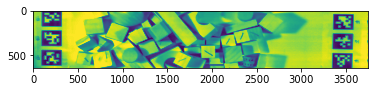

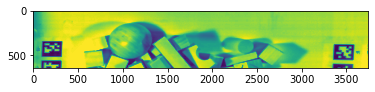

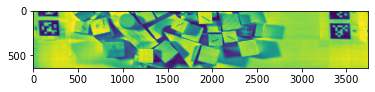

In [5]:
raw_cubes = []

# Process each cube from the list of filepaths to create an indicative greyscale image, then add it to the list of images
for cube_index in range(len(HSI_CUBE_PATHS)):
    raw_cubes.append(np.load(HSI_CUBE_PATHS[cube_index]).astype(np.float32))
    img = create_image_from_cube(raw_cubes[cube_index])
    hsi.append(img)
    
clahe = cv.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
hsi_improved = []
for x in range(len(HSI_CUBE_PATHS)):
    dst = cv.fastNlMeansDenoising(hsi[x],None,10,9,21)
    cl1 = clahe.apply(dst)
    hsi_improved.append(cl1.copy())
    
for image in hsi_improved:
    plt.figure()
    plt.imshow(image)

In [6]:
MIN_MATCH_COUNT = 10
sift = cv.SIFT_create()
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 50)
flann = cv.FlannBasedMatcher(index_params, search_params)

# Given two images, returns the perspective transform between the child and parent
def determine_homography(child: np.ndarray, parent: np.ndarray) -> np.ndarray:
    kp1, des1 = sift.detectAndCompute(child, None)
    kp2, des2 = sift.detectAndCompute(parent, None)
    matches = flann.knnMatch(des1,des2,k=2)
    good = []
    for m, n in matches:
        if m.distance < .7 * n.distance: #tutorial has 0.7*n.distance, increase thresh for more matches
            good.append(m)
    
    assert len(good) > MIN_MATCH_COUNT, f"Needed to find {MIN_MATCH_COUNT} matches, instead only found {len(good)}"
    src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
    M, mask = cv.findHomography(src_pts, dst_pts, cv.RANSAC, 5.0)
    
    return M


In [7]:
# Given two images and their perspective transform, combine the two images, and return the transform 
def warpTwoImages(child: np.ndarray, parent: np.ndarray, M: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    '''warp parent to child with homograph M'''
    h1,w1 = child.shape[:2]
    h2,w2 = parent.shape[:2]
    pts1 = np.float32([[0,0],[0,h1],[w1,h1],[w1,0]]).reshape(-1,1,2)
    pts2 = np.float32([[0,0],[0,h2],[w2,h2],[w2,0]]).reshape(-1,1,2)
    pts2_ = cv.perspectiveTransform(pts2, M)
    pts = np.concatenate((pts1, pts2_), axis=0)
    [xmin, ymin] = np.int32(pts.min(axis=0).ravel() - 0.5)
    [xmax, ymax] = np.int32(pts.max(axis=0).ravel() + 0.5)
    t = [-xmin,-ymin]
    Ht = np.array([[1,0,t[0]],[0,1,t[1]],[0,0,1]]) # translate

    H =  Ht.dot(M)
    result = cv.warpPerspective(parent, H, (xmax-xmin, ymax-ymin))
    result[t[1]:h1+t[1],t[0]:w1+t[0]] = child
    return result, H

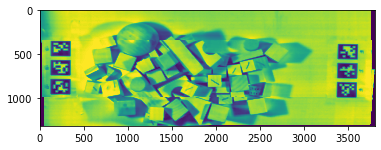

In [8]:
perspective_transforms = []
cumulative_hsi_dim = []

assert len(hsi) >= 1, "Need at least one image"

if(cumulative_hsi is None):
    cumulative_hsi = hsi_improved[0]
    M = determine_homography(hsi_improved[0], hsi_improved[0])
    comb, H = warpTwoImages(hsi_improved[0], hsi_improved[0], M)
    
for image in hsi_improved[1:]:
    M = determine_homography(image, cumulative_hsi)
    perspective_transforms.append(M)
    cumulative_hsi, H = warpTwoImages(cumulative_hsi, image, M)
    cumulative_hsi_dim.append(cumulative_hsi.shape)

plt.imshow(cumulative_hsi)

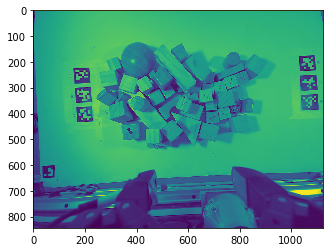

In [9]:
kinect_img = cv.imread(KINECT_IMG_PATH, 0)
plt.imshow(kinect_img)
M = determine_homography(cumulative_hsi, kinect_img)
h, w = kinect_img.shape
cumulative_hsi_dim.append((h, w))
perspective_transforms.append(M)

In [10]:
for cube in range(len(raw_cubes)):
    raw_cubes[cube] = normalize(raw_cubes[cube])
    adapted = np.flip(raw_cubes[cube],axis=0)
    adapted = np.rot90(adapted)
    raw_cubes[cube] = adapted

In [11]:
initial_warp = []
acc_cube = []
for cube in range(len(raw_cubes) - 1):
    
    initial_warp.append(warpTwoImages(raw_cubes[cube][:,:,0], 
                            raw_cubes[cube + 1][:,:,0], 
                            perspective_transforms[cube])[0])
    
    acc_cube.append(np.zeros((*(initial_warp[cube].shape), NUM_WAVELENGTHS), dtype=np.float32))
        
    for wave in range(NUM_WAVELENGTHS):
        if(len(acc_cube) == 1):
            comp = raw_cubes[0][:,:,wave]
        else:
            comp = acc_cube[cube - 1][:,:,wave]
            
        acc_cube[cube][:,:,wave], _ = warpTwoImages(comp, 
                                                   raw_cubes[cube + 1][:,:,wave],
                                                   perspective_transforms[cube])
        
acc_cube.append(np.zeros((*kinect_img.shape, NUM_WAVELENGTHS), dtype=np.float32))

for wave in range(NUM_WAVELENGTHS):
    acc_cube[-1][:,:,wave] = cv.warpPerspective(acc_cube[-2][:,:,wave],
                                                perspective_transforms[-1],
                                                acc_cube[-1].shape[:2][::-1])

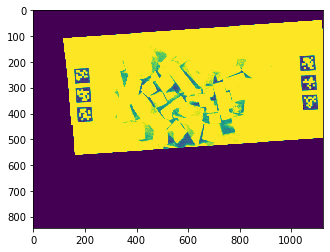

In [12]:
raw_cubes = []
acc_cube[:-1] = []

plt.imshow(acc_cube[0][:,:,30])